In [1]:
import datetime
import json
import os
import pathlib

import cv2
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, models
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tqdm import tqdm

2025-01-20 21:55:37.135938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737420939.025189  136276 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737420939.481006  136276 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 21:55:43.950031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_path = pathlib.Path(os.getcwd(), "..", "..").resolve()

class Config:
    experiments_path = pathlib.Path(os.path.join(base_path, "experiments", "autoencoder")).resolve()
    dataset_path = pathlib.Path(os.path.join(base_path, "data", "categorized_images")).resolve()
    patience = 50
    epochs = 1000
    batch_size = 8
    encoding_dim = 128
    imgsz = 128
    n_clusters = 4

os.makedirs(Config.experiments_path, exist_ok=True)

In [3]:
print(Config.experiments_path)

/mnt/c/Users/Ricardo/Documents/Development/tcc-1/experiments/autoencoder


In [4]:
def build_autoencoder(input_shape, encoding_dim):
    inputs = tf.keras.Input(shape=input_shape, name="encoder_input")

    # Encoder
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(
        64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(
        128, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

    # Calculate shape before flattening
    shape_before_flattening = x.shape[1:]  # (H, W, C)
    flattened_dim = int(np.prod(shape_before_flattening))  # Convert to integer

    x = tf.keras.layers.Flatten()(x)
    encoded = tf.keras.layers.Dense(
        encoding_dim, activation="relu", name="latent")(x)

    # Decoder
    x_dec = tf.keras.layers.Dense(
        flattened_dim, activation="relu", name="dec_dense")(encoded)
    x_dec = tf.keras.layers.Reshape(shape_before_flattening)(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        128, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        64, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    x_dec = tf.keras.layers.Conv2DTranspose(
        32, (3, 3), strides=2, activation="relu", padding="same")(x_dec)
    decoded = tf.keras.layers.Conv2D(
        3, (3, 3), activation="sigmoid", padding="same")(x_dec)

    autoencoder = tf.keras.Model(inputs, decoded, name="autoencoder")
    encoder = tf.keras.Model(inputs, encoded, name="encoder")

    return autoencoder, encoder

In [5]:
# Build models
autoencoder, encoder = build_autoencoder(
    input_shape=(Config.imgsz, Config.imgsz, 3), encoding_dim=Config.encoding_dim
)

I0000 00:00:1737421017.915919  136276 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


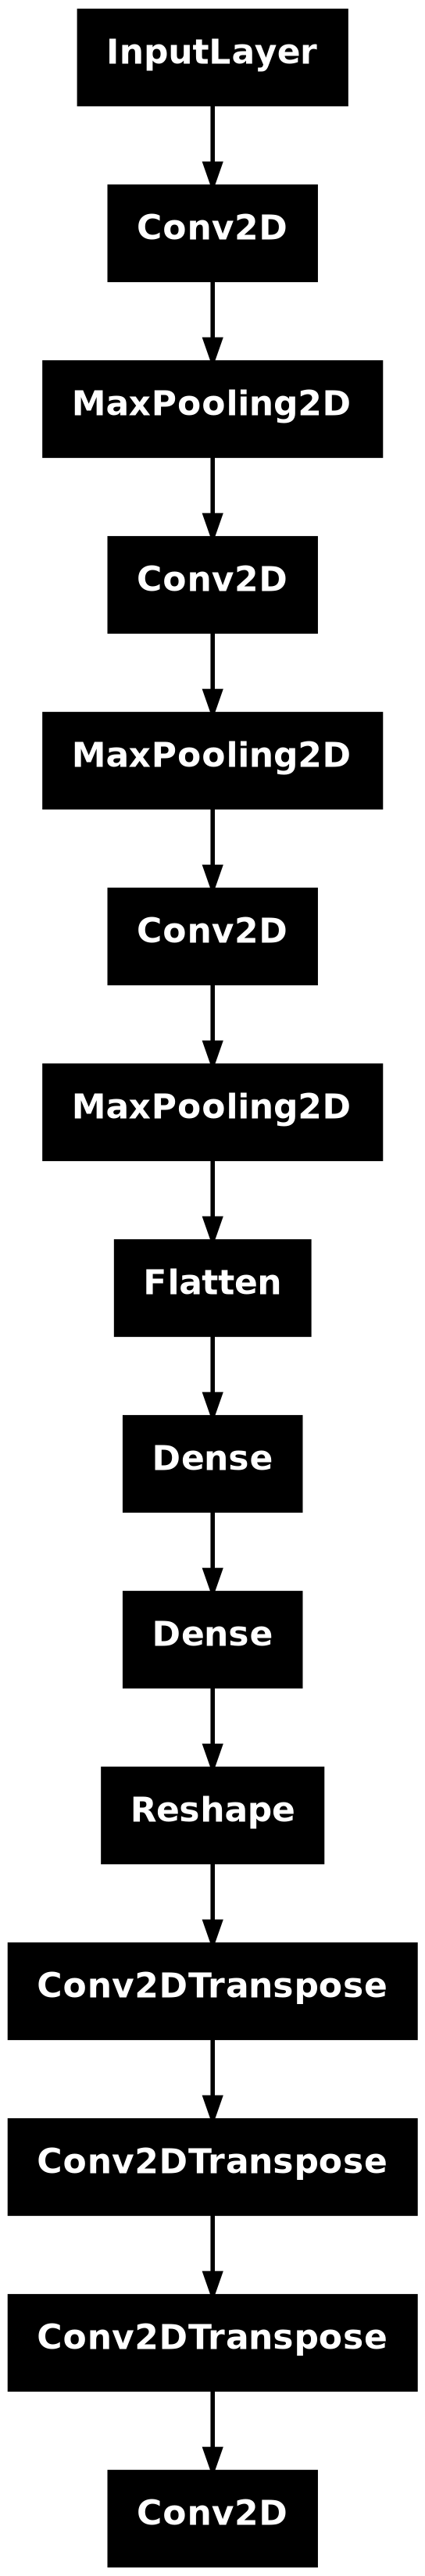

In [6]:
# Save autoencoder
autoencoder.save(os.path.join(Config.experiments_path, "autoencoder_no_train.keras"))
keras.utils.plot_model(autoencoder, os.path.join(Config.experiments_path, "autoencoder.png"), show_shapes=True)
keras.utils.plot_model(autoencoder, os.path.join(Config.experiments_path, "autoencoder_no_shapes.png"), show_shapes=False)

In [7]:
def show_cluster_examples(dataset, tsne_embeddings, cluster_labels, n_examples=5):
    """
    Mostra exemplos de imagens pertencentes a cada cluster.
    
    Args:
    - dataset: Dataset original usado para t-SNE (formato (input, input)).
    - tsne_embeddings: Embeddings do t-SNE (array de shape (N, 2)).
    - cluster_labels: Rótulos dos clusters gerados (array de shape (N,)).
    - n_examples: Número de exemplos para mostrar de cada cluster.
    """
    unique_clusters = np.unique(cluster_labels)
    # Convertendo o dataset para iterador NumPy
    dataset_iterator = dataset.unbatch().as_numpy_iterator()

    # Carregar todas as imagens para acesso rápido
    # Usar apenas as imagens de entrada
    all_images = [pair[0] for pair in dataset_iterator]
    all_images = np.array(all_images)

    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, min(
            n_examples, len(cluster_indices)), replace=False)

        # Mostrar exemplos do cluster
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Cluster {cluster}", fontsize=16)

        for i, idx in enumerate(selected_indices):
            plt.subplot(1, n_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.title(f"Point {idx}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

In [8]:
def extract_embeddings(dataset, encoder, subdataset_name):
    embeddings = []
    dataset_iterator = dataset.unbatch().as_numpy_iterator()
    total_images = sum(1 for _ in dataset_iterator)

    for image_pair in tqdm(dataset.unbatch(), total=total_images, desc=f"Extracting Embeddings for {subdataset_name}"):
        embeddings.append(encoder.predict(
            image_pair[0][tf.newaxis, ...], verbose=0))

    return np.vstack(embeddings)

In [9]:
def find_optimal_clusters(embeddings, max_clusters=10):
    from sklearn.metrics import silhouette_score

    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(score)

    optimal_clusters = np.argmax(silhouette_scores) + 2
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker="o")
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

    return optimal_clusters

In [10]:
import pathlib

import numpy as np
from PIL import Image


def get_image_dimensions(directory):
    """
    Retorna uma lista com a 'dimensão' (maior lado, por exemplo)
    para cada imagem no 'directory', na mesma ordem dos arquivos.
    """
    # Lista de caminhos (sem shuffle) — importante para manter ordem
    all_files = sorted(list(directory.glob("*.*")))

    dims = []
    for file_path in all_files:
        try:
            with Image.open(file_path) as img:
                w, h = img.size
                # Escolhemos a maior dimensão:
                dims.append(max(w, h))
        except:
            # Se ocorrer algum erro, podemos ignorar ou colocar algo padrão
            dims.append(0)
    return all_files, np.array(dims)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


def create_dataset_no_shuffle(directory, target_size=(128, 128), batch_size=8):
    # Cria dataset *sem* shuffle para manter ordem
    dataset = image_dataset_from_directory(
        directory,
        labels=None,
        batch_size=batch_size,
        image_size=target_size,
        shuffle=False
    ).map(lambda x: (x/255.0, x/255.0))
    return dataset

In [12]:
def extract_embeddings_in_order(dataset, encoder):
    """
    Extrai embeddings do encoder batch a batch.
    Retorna um array (N, encoding_dim), onde N é
    a quantidade total de imagens.
    """
    all_embeddings = []
    for batch_in, _ in dataset:
        emb_batch = encoder.predict(batch_in, verbose=0)
        all_embeddings.append(emb_batch)

    embeddings = np.concatenate(all_embeddings, axis=0)
    return embeddings

In [13]:
def get_median_dimension(directory: pathlib.Path) -> int:
    """
    Lê todas as imagens no diretório e retorna a mediana
    do maior lado (largura ou altura) de cada imagem.
    Se não houver imagens, retorna 128 como valor padrão.
    """
    # Filtra apenas arquivos de imagem
    all_files = list(directory.glob("*.*"))
    # Opcional: filtrar extensões específicas se necessário:
    # all_files = [f for f in all_files if f.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]]

    dims = []
    for file_path in all_files:
        try:
            with Image.open(file_path) as img:
                w, h = img.size
                # pega a maior dimensão entre largura e altura
                dims.append(max(w, h))
        except:
            # Caso haja erro ao abrir um arquivo, simplesmente ignore
            continue

    if not dims:
        # Caso não haja imagens válidas
        return 128

    # Calcula a mediana
    median_dim = int(np.median(dims))
    return median_dim

In [14]:
import math


def round_to_nearest_power2(value: int) -> int:
    """
    Arredonda um valor inteiro para a potência de 2 mais próxima.
    Exemplo: 
      Se value=130, retorna 128.
      Se value=200, retorna 256.
    """
    if value <= 0:
        return 1  # caso de borda, se value for 0 ou negativo
    # log2(value)
    power = round(math.log2(value))
    return 2**power

In [15]:
# -------------------------------------------------------
# 3) Visualizações adaptadas para colorir por dimensão
# -------------------------------------------------------

def visualize_tsne_2D(embeddings, cluster_labels, dims_array, subdataset_name=""):
    """
    Plota:
      1) t-SNE colorido pelos clusters
      2) t-SNE (puro)
      3) t-SNE colorido pela dimensão do arquivo
    """
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(cluster_labels)
    for cluster in unique_labels:
        cluster_points = embeddings[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    label=f"Cluster {cluster}", alpha=0.6)
    plt.legend()
    plt.title(f"t-SNE Clusters {subdataset_name} (2D)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

    # Plot 2: t-SNE puro
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6)
    plt.title(f"t-SNE (2D) - {subdataset_name}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

    # Plot 3: colorir pela dimensão
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                     c=dims_array, cmap='viridis', alpha=0.6)
    cbar = plt.colorbar(sc)
    cbar.set_label("Dimensão da imagem (maior lado)")
    plt.title(f"t-SNE colorido pela Dimensão - {subdataset_name}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()


def visualize_tsne_3D(embeddings, cluster_labels, dims_array, subdataset_name=""):
    """
    Plota (3D):
      1) t-SNE colorido pelos clusters
      2) t-SNE puro
      3) t-SNE colorido pela dimensão
    """
    from mpl_toolkits.mplot3d import Axes3D

    # Plot 1: clusters
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(cluster_labels)
    for cluster in unique_labels:
        cluster_points = embeddings[cluster_labels == cluster]
        ax.scatter(cluster_points[:, 0],
                   cluster_points[:, 1],
                   cluster_points[:, 2],
                   label=f"Cluster {cluster}", alpha=0.6)
    ax.legend()
    ax.set_title(f"t-SNE Clusters (3D) - {subdataset_name}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_zlabel("Dim 3")
    plt.show()

    # Plot 2: puro
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], alpha=0.6)
    ax.set_title(f"t-SNE (3D) - {subdataset_name}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_zlabel("Dim 3")
    plt.show()

    # Plot 3: colorido pela dimensão
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(embeddings[:, 0],
                    embeddings[:, 1],
                    embeddings[:, 2],
                    c=dims_array,
                    cmap='viridis',
                    alpha=0.6)
    plt.colorbar(sc, label='Dimensão da imagem')
    ax.set_title(f"t-SNE (3D) colorido pela Dimensão - {subdataset_name}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_zlabel("Dim 3")
    plt.show()

In [16]:
import matplotlib.pyplot as plt


def compare_autoencoder_reconstruction(autoencoder, dataset, num_images=5):
    """
    Extrai um único batch do 'dataset', passa as imagens pelo 'autoencoder'
    e plota lado a lado a imagem de entrada e a reconstruída, para análise visual.

    Args:
        autoencoder: Modelo treinado (autoencoder).
        dataset: tf.data.Dataset no formato (imagens, imagens).
        num_images: Quantidade máxima de imagens para exibir (caso o batch seja maior).

    Returns:
        None (apenas exibe o plot).
    """
    # Pega apenas 1 batch do dataset
    sample_dataset = dataset.take(1)  # take(1) -> pega o primeiro batch
    sample_batch = next(iter(sample_dataset))

    # sample_batch é uma tupla (x, x) para um autoencoder
    input_images = sample_batch[0]  # Imagens de entrada normalizadas

    # Gera reconstruções
    reconstructed = autoencoder.predict(input_images, verbose=0)

    # Determina quantas imagens serão mostradas (limitado pelo num_images ou pelo tamanho do batch)
    n = min(num_images, input_images.shape[0])

    # Cria subplots 2xN
    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
    fig.suptitle("Comparação: Entrada vs Reconstrução", fontsize=16)

    # Itera sobre as imagens que serão mostradas
    for i in range(n):
        # Entrada
        axes[0, i].imshow(input_images[i].numpy())
        axes[0, i].axis("off")
        axes[0, i].set_title("Entrada")

        # Reconstrução
        axes[1, i].imshow(reconstructed[i])
        axes[1, i].axis("off")
        axes[1, i].set_title("Reconstrução")

    plt.tight_layout()
    plt.show()

In [17]:
def process_dataset(subdataset_path, subdataset_name):
    print(f"Processing subdataset: {subdataset_name}")

    imgsz = Config.imgsz
    if subdataset_name != 'all':
        # 1) Obtém a mediana do maior lado
        median_dim = get_median_dimension(subdataset_path)
        # 2) Arredonda para potência de 2
        dim = round_to_nearest_power2(median_dim)

        print(f"Dimension used for resizing: {dim}")
        imgsz = (dim, dim)

    # Carregar o dataset
    train_dataset = image_dataset_from_directory(
        subdataset_path,
        labels=None,
        image_size=imgsz,
        batch_size=Config.batch_size,
        shuffle=True
    ).map(lambda x: (x / 255.0, x / 255.0))

    # Construir e treinar o autoencoder
    autoencoder, encoder = build_autoencoder(
        (Config.imgsz, Config.imgsz, 3), Config.encoding_dim)
    autoencoder.compile(optimizer="adam", loss="mse")

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss", patience=Config.patience, restore_best_weights=True
    )
    
    autoencoder.fit(train_dataset.repeat(), epochs=Config.epochs,
                    steps_per_epoch=len(train_dataset) // Config.batch_size,
                    callbacks=[early_stopping])

    # validar a reconstrução
    compare_autoencoder_reconstruction(autoencoder, train_dataset, 2)

    # -----------------------
    # B) Dataset de Análise (shuffle=False) para extrair dims e embeddings
    # -----------------------
    # 1) Obtem lista de arquivos e dims na ordem
    files_list, dims_array = get_image_dimensions(subdataset_path)
    # 2) Cria dataset sem shuffle
    # analysis_dataset = create_dataset_no_shuffle(
    #     files_list, target_size=imgsz, batch_size=Config.batch_size)


    # Extrair embeddings
    embeddings = extract_embeddings(train_dataset, encoder, subdataset_name)

    # Encontrar número ótimo de clusters
    optimal_clusters = find_optimal_clusters(embeddings)
    print(f"Optimal number of clusters: {optimal_clusters}")

    use_3d = False

    # Clusterização e visualização
    tsne = TSNE(n_components=3 if use_3d else 2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_embeddings)

    if use_3d:
        visualize_tsne_3D(tsne_embeddings, cluster_labels,
                          dims_array, subdataset_name)
    else:
        visualize_tsne_2D(tsne_embeddings, cluster_labels,
                          dims_array, subdataset_name)

In [18]:
import tensorflow as tf

print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:

# Iterar sobre os subdatasets
subdatasets = [d for d in Config.dataset_path.iterdir() if d.is_dir()]

Processing subdataset: all
Found 3406 files.
Epoch 1/1000


I0000 00:00:1737421036.644858  137296 service.cc:148] XLA service 0x2291d4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737421036.645750  137296 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-01-20 21:57:17.003450: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737421037.593760  137296 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/53 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0677  

I0000 00:00:1737421047.901696  137296 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0641
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0469
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0304
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0210
Epoch 5/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0166
Epoch 6/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0170
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0142
Epoch 8/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0143
Epoch 9/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0138
Epoch 10/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0126
Epoch 11/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0120
Epoch 12/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0112
Epoch 13/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0109
Epoch 14/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0117
Epoch 15/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

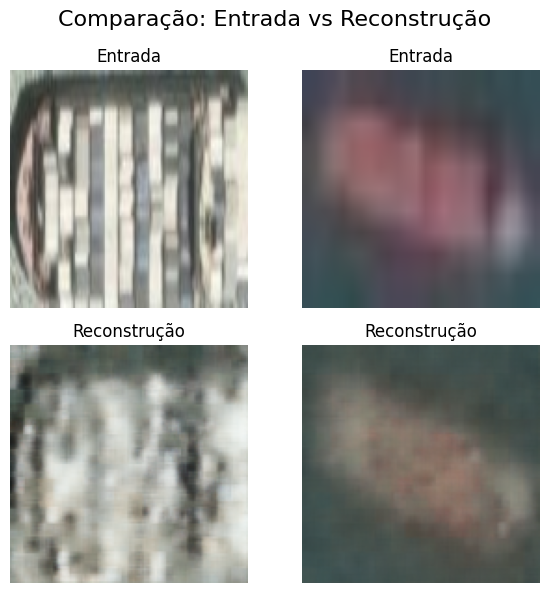

2025-01-20 22:03:21.117957: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Extracting Embeddings for all: 100%|██████████| 3406/3406 [04:09<00:00, 13.66it/s]


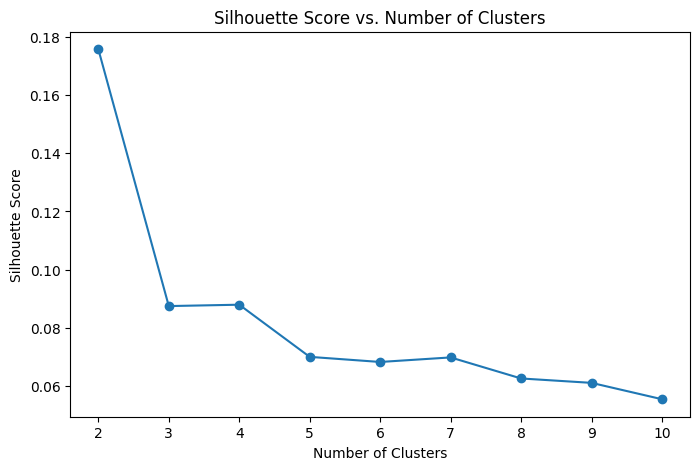

Optimal number of clusters: 2


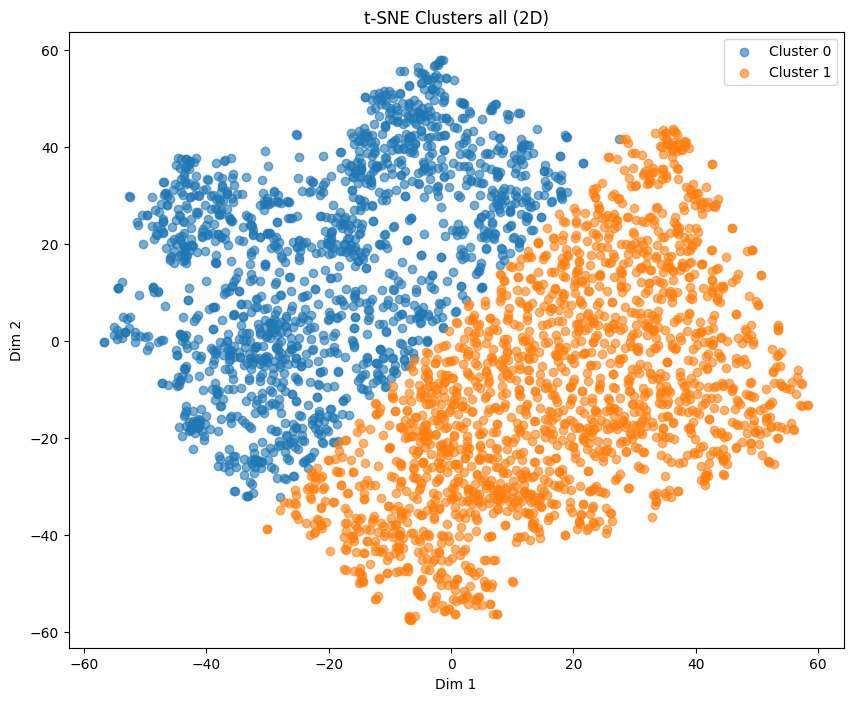

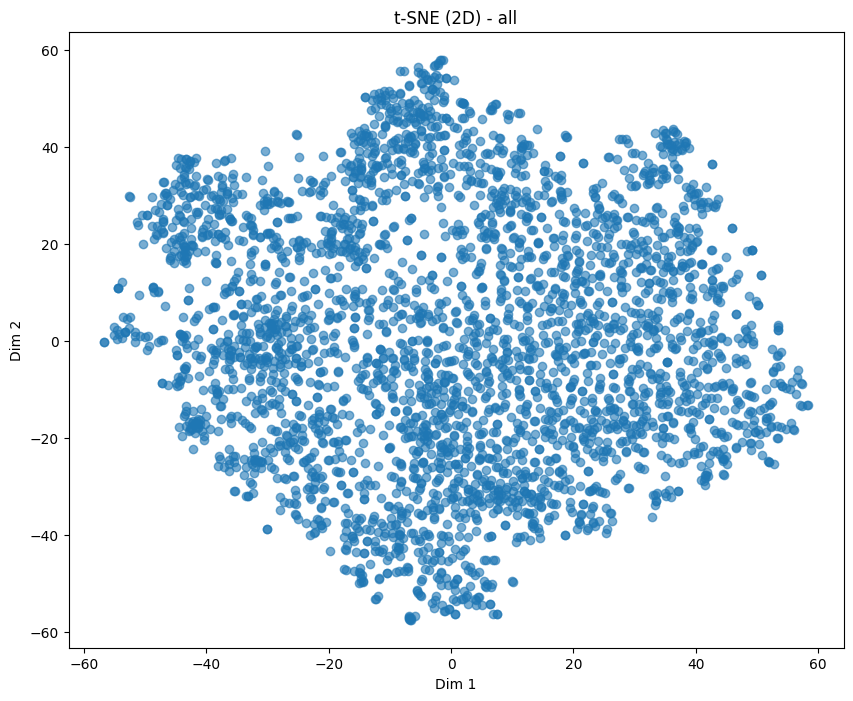

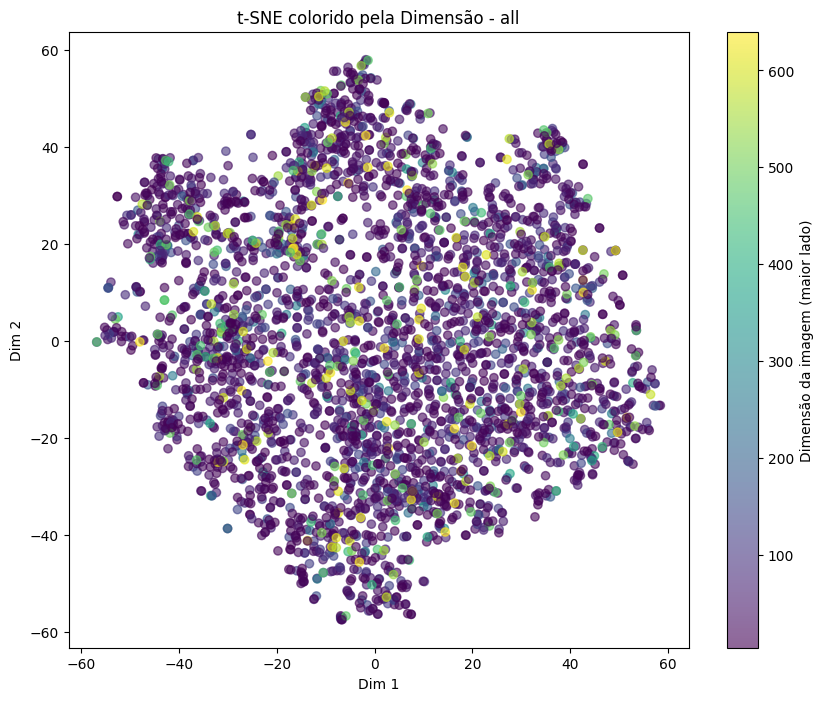

Processing subdataset: large
Dimension used for resizing: 512
Found 956 files.
Epoch 1/1000



KeyboardInterrupt



In [20]:
for subdataset in subdatasets:
    process_dataset(subdataset, subdataset.name)